# H1.0 orthologs
The purpose of this experiment is to structurally characterise H1.0 orthologs across eukaryotes

In [1]:
# Imports
import requests
import pandas as pd
import json
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import mdtraj as md
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import pearsonr, spearmanr

sys.path.append('../../src')
import data_utils
import analyse_utils
from residues import residues

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.weight"] = "normal"

## Data preparation

### Quering orthologs from OrthoDB

API-documentation: https://www.ezlab.org/orthodb_userguide.html#api

Ortho DB groups:
- [histone H1.0](https://www.orthodb.org/?query=19111at9604)
    - 5363206at2759 at Eukaryota level
    - 2491618at33208 at Metazoa level
    - 1590200at7742 at Vertebrata level
    - 1033145at32523 at Tetrapoda level
    - 21759at40674 at Mammalia level
    - 97195at9347 at Eutheria level
    - 97195at314146 at Euarchontoglires level
    - 97195at9443 at Primates level
    - 19111at314295 at Hominoidea level (1)
    - 19111at9604 at Hominidae level (2)

In [194]:
# Querying API
group = '5363206at2759'
url = f"https://data.orthodb.org/current/orthologs?id={group}"
response = requests.get(url).json()

In [ ]:
# Saving to metadata
with open('H1-0_orthodb.json', 'w') as file:
    json.dump(response, file, indent=4)

### Templates

In [195]:
# Extracting entries from OrthoDB
with open('H1-0_orthodb.json') as file:
    data = json.load(file)

# Extracting UniProt IDs
uids = []
uids_species = []
no_uids_ids = []
no_uids_species = []
for id in range(len(data['data'])):

    # Skipping species without UniProt entries
    try:
        for protein in data['data'][id]['genes']:
            uids.append(protein['uniprot']['id'])
            uids_species.append(data['data'][id]['organism']['name'])
    except KeyError:
        no_uids_ids.append(data['data'][id]['genes'][0]['gene_id']['param'])
        no_uids_species.append(data['data'][id]['organism']['name']) 

# Handling proteins with no UniProt IDs
if no_uids_species:
    print(f"The following {len(no_uids_species)}/{len(data['data'])} entries had no UniProt IDs")
    print(*[f" - {specie}" for specie in no_uids_species], sep="\n")

# Defining UniProt IDs
templates = pd.DataFrame({'uniprot_id': uids,
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None})

The following 319/485 entries had no UniProt IDs
 - Cyprinodon tularosa
 - Gambusia affinis
 - Girardinichthys multiradiatus
 - Nematolebias whitei
 - Poecilia formosa
 - Poecilia reticulata
 - Xiphophorus hellerii
 - Archocentrus centrarchus
 - Simochromis diagramma
 - Acanthopagrus latus
 - Alosa alosa
 - Alosa sapidissima
 - Anarrhichthys ocellatus
 - Anguilla anguilla
 - Boleophthalmus pectinirostris
 - Cheilinus undulatus
 - Chelmon rostratus
 - Colossoma macropomum
 - Coregonus clupeaformis
 - Cyclopterus lumpus
 - Cyprinus carpio
 - Denticeps clupeoides
 - Echeneis naucrates
 - Electrophorus electricus
 - Epinephelus lanceolatus
 - Erpetoichthys calabaricus
 - Etheostoma cragini
 - Etheostoma spectabile
 - Gadus morhua
 - Gasterosteus aculeatus aculeatus
 - Gouania willdenowi
 - Hippoglossus hippoglossus
 - Hippoglossus stenolepis
 - Hypomesus transpacificus
 - Lates calcarifer
 - Lepisosteus oculatus
 - Megalobrama amblycephala
 - Megalops cyprinoides
 - Micropterus dolomieu
 -

In [4]:
# Collecting metadata
deleted_records = []
for id, row in templates.iterrows():
    try:
        name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    except:
        deleted_records.append(id)
        continue
    templates.loc[id] = {
            'uniprot_id': row.uniprot_id,
            'name': name,
            'description': desc,
            'species': spec,
            'sequence': seq}
    
# Discarding deleted UniProt records
if deleted_records:
    print(f"The following {len(deleted_records)}/{len(templates)} UniProt IDs returned no records:")
    for id in deleted_records:
        print(f" - {templates.loc[id].uniprot_id}")
    templates.drop(index=deleted_records, inplace=True)

The following 4/199 UniProt IDs returned no records:
 - A0A5F4D9L8
 - G3W6X3
 - A0A6I9JUI2
 - A0A1L8GP11


Some hits from the BLAST are irrelevant, as they are most likely not orthologs, like:
- "Uncharacterized protein"
- "8-amino-7-oxononanoate synthase-like"

Additionally, some hits are more subtle orthologs, like other members of the H15 superfamily:
- "H5 protein"
- "H15 domain-containing protein"

Lastly, some are in a grey area of  the H1.0 definition:
- "histone H1.0-like"
- "Histone H1.0-B"
- "histone H1.0-B-like"
- "H1 histone family, member 0"

This section is used to specify the names of the orthologs to be used for analysis

In [11]:
# Finding all unique descriptions / names
templates['description'].value_counts()

histone H1.0                               37
Histone H1.0                               30
H1.0 linker histone                        28
Histone H1.0-B                             22
H15 domain-containing protein              17
Histone H5                                 11
histone H1.0-like                          11
histone H1.0-B                              6
Histone H1.0-B-like                         6
Linker histone H1 and H5 family protein     5
Histone H1.0-like                           3
histone H5                                  3
histone H1.0-B-like                         2
late histone H1-like                        2
H1 histone family, member 0 like 1          1
H1 histone family member 0 like protein     1
8-amino-7-oxononanoate synthase-like        1
Putative histone h1.0                       1
Uncharacterized protein                     1
H1F0 isoform 1                              1
Histone H1-beta, late embryonic             1
Histone H1                        

In [12]:
# Setting description requirements
required  = ['H1', 'h1', 'H5', 'h5']

# Filtering off
filtered = templates[templates.apply(lambda row: max([req in row['description'] for req in required]), axis=1)]

# Displaying proteins that were filtered off
templates.loc[list(set(templates.index) - set(filtered.index))]

,uniprot_id,name,description,species,sequence
74_9SAUR,A0A6I9XPX0,A0A6I9XPX0_9SAUR,8-amino-7-oxononanoate synthase-like,Thamnophis sirtalis,MWCSQFFRSPFVLGQCSPSRAQSALAQLKHLLEGELEGIRGAGTWK...
190_CAEBR,A8Y2Z3,A8Y2Z3_CAEBR,Protein CBG22701,Caenorhabditis briggsae,MHCFAITPTPEGSPAPEDSPVAAQTTPKRPAATPAKARKAKRGPGR...
109_SHEEP,A0A6P3E3Z9,A0A6P3E3Z9_SHEEP,Uncharacterized protein,Ovis aries (Sheep),MTENSTSTPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...


In [13]:
# Setting IDs from integer range and UniProt name
templates.reset_index(inplace=True)
templates.index = templates.index.astype(str) + '_' + templates.name.map(lambda n: n.split('_')[-1])

In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('ortho_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### IDRs

In [196]:
# Getting template metadata
with open('ortho_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [3]:
# Getting CTD
length_order=False
i_idr=-1
region_filter = ['CTD']

In [4]:
# Getting IDR regions
IDRs = []
not_IDP = []
for id, fields in metadata['templates'].items():
    try:
        seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
        IDRs.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
    except ValueError:
        not_IDP.append((id, fields['uniprot_id']))
if not_IDP:
    print(f"The following {len(not_IDP)}/{len(metadata['templates'])} UniProt IDs did not return IDPs:")
    print(*[f" - {uid}\t({id})" for id, uid in not_IDP], sep='\n')
data = pd.DataFrame(IDRs)

The following 1/192 UniProt IDs did not return IDPs:
 - A0A1L8GH50	(171_XENLA)


In [5]:
# Filtering according to CTD/NTD settings
wrong_region = data[~data['region'].isin(region_filter)]
if len(wrong_region) > 0:
    print(f"The following UniProt IDs had no {region_filter[0]} IDR")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in wrong_region['template']],sep='\n')
data = data.loc[list(set(data.index) - set(wrong_region.index))]

The following UniProt IDs had no CTD IDR
 - W2TL48


In [6]:
# Removing fragment sequences (contains amino acid 'X')
fragments = data[data['sequence'].str.contains('X')]
if len(fragments) > 0:
    print("The following UniProt IDs were fragments containing 'X' in their sequence")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in fragments['template']],sep='\n')
data = data.loc[list(set(data.index) - set(fragments.index))]

The following UniProt IDs were fragments containing 'X' in their sequence
 - A0A2R2MRR7


In [7]:
# Generating wild type IDRs
data['variant'] = 'Wild type'

In [8]:
# Viewing final data
data

,template,sequence,location,region,variant
0,0_AUSLI,HTKGIGASGSFRLTKPEDSSKKPAKAAAAVAAKPKKVAKAKPKKAA...,80:197,CTD,wt
1,1_CYPVA,RHTKGIGASGSFRLTKPEDTKKPAAKAASAPKPKKVVKPKPKKAAK...,78:194,CTD,wt
2,2_FUNHE,RHTKGIGASGSFRLTKPEDTKKTPAKAASAAKPRKVAKPKPKKAAK...,79:195,CTD,wt
3,3_KRYMA,HTKGIGASGSFRLTKPEDSSKKPAKAAAAAASAKPKKVAKPKPKKA...,80:198,CTD,wt
4,4_NOTFU,RHTKGIGASGSFRLTKPEDSKKPAKAAASAKPKKVAKPKPKKAAKP...,79:194,CTD,wt
...,...,...,...,...,...
186,190_NECAM,RKEVVRKEAAQKAKPTRNTTGSSSRKTVKSVKKSTASRV,168:207,CTD,wt
187,191_STRRB,KKSSEAKKVTDSKKSTDVKKTPETKKAVKAPKAKATEKKVLKKAIV...,138:221,CTD,wt
188,192_CAPO3,AAALPKAAKAPKAAKAPKAEKPAKAAKAPKADKPAKAAKAPKAAKA...,213:355,CTD,wt
189,193_STRPU,RHVKGSGASGSFLLAEKTKTPKKAAAKKATPKKKPAAKKTKKPAAK...,89:185,CTD,wt


In [ ]:
# Saving sequences
# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [ ]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('para_h1.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Check disorder predictions

/tmp/ipykernel_19743/4196263198.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


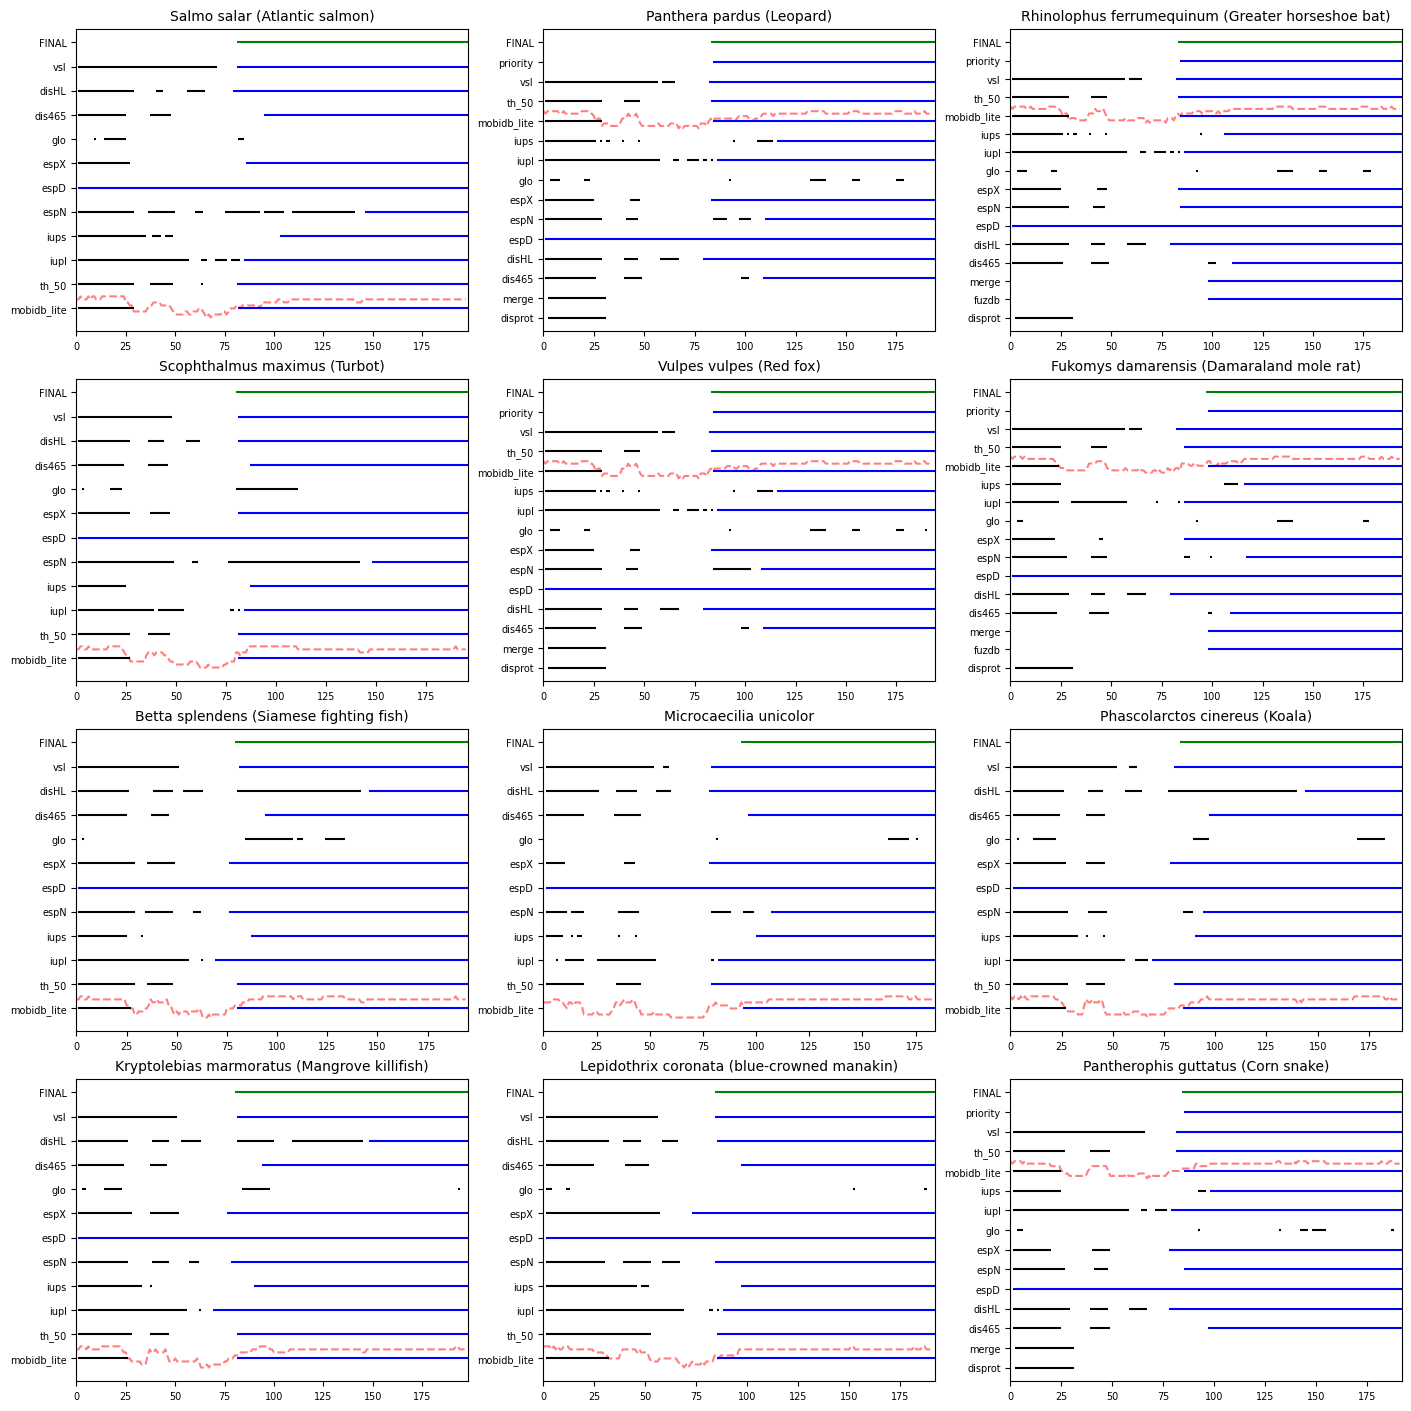

In [ ]:
# Sampling uniprot IDs
metadata = analyse_utils.load_metadata('ortho_h1-0.json')
metadata = metadata.sample(12)
metadata.set_index('uniprot_id', inplace=True, drop=False)
uniprot_ids = metadata.uniprot_id

# Building fig layout
cols = int(np.floor(np.sqrt(len(uniprot_ids))))
rows = len(uniprot_ids)//cols
fig, axes = plt.subplots(rows, cols, constrained_layout=True)

# Looping over uniprot IDs
for i, uid in enumerate(uniprot_ids):
    if rows == 1:
        ax = axes
    elif cols == 1:
        ax = axes[i]
    else:
        ax = axes[i%rows,i//rows]

    # Querying MobiDB
    response = requests.get(f"https://mobidb.org/api/download", params={'acc': [uid]}).json()
    disorder_regions = {k.split('-')[-1]: response[k]['regions'] for k in response if 'disorder' in k and 'regions' in response[k]}
    disorder_scores = {k.split('-')[-1]: response[k]['scores'] for k in response if 'disorder' in k and 'scores' in response[k]}

    # Plotting MobiDB data
    for j, k in enumerate(disorder_regions):
        # Plotting scores
        if k in disorder_scores:
            ax.plot(range(len(response['sequence'])), [v-0.5+j for v in disorder_scores[k]], 'r--', alpha=0.5)
        # Plotting predicted IDRs
        for region in disorder_regions[k]:
            start, end = region

            # Painting C-terminal IDRs
            if end == len(response['sequence']):
                c = 'b'
            else:
                c = 'k'
                
            ax.hlines(j, start, end, c)

    # Plotting annoted region
    start, end = metadata.location[uid].split(':')
    ax.hlines(len(disorder_regions), int(start), int(end), 'g')

    # Setting labels
    ax.set_xlim(0, len(response['sequence']))
    ax.set_yticks(range(len(disorder_regions)+1))
    ax.set_yticklabels([*disorder_regions.keys(), 'FINAL'])
    ax.tick_params(labelsize=7)
    ax.set_title(metadata.loc[uid,'species'], size=10)

fig.set_size_inches(14, 14)
fig.show()

## Analysis

In [2]:
# Loading metadata
metadata = analyse_utils.load_metadata('ortho_h1-0.json')
metadata

,template,sequence,location,region,variant,species,description,uniprot_id,name
0_AUSLI,0_AUSLI,HTKGIGASGSFRLTKPEDSSKKPAKAAAAVAAKPKKVAKAKPKKAA...,80:197,CTD,Wild type,Austrofundulus limnaeus (Annual killifish),histone H1.0-B,A0A2I4B7C3,A0A2I4B7C3_AUSLI
1_CYPVA,1_CYPVA,RHTKGIGASGSFRLTKPEDTKKPAAKAASAPKPKKVVKPKPKKAAK...,78:194,CTD,Wild type,Cyprinodon variegatus (Sheepshead minnow),Histone H1.0-B,A0A3Q2C803,A0A3Q2C803_CYPVA
2_FUNHE,2_FUNHE,RHTKGIGASGSFRLTKPEDTKKTPAKAASAAKPRKVAKPKPKKAAK...,79:195,CTD,Wild type,Fundulus heteroclitus (Killifish),Histone H1.0-B,A0A3Q2Q6G9,A0A3Q2Q6G9_FUNHE
3_KRYMA,3_KRYMA,HTKGIGASGSFRLTKPEDSSKKPAKAAAAAASAKPKKVAKPKPKKA...,80:198,CTD,Wild type,Kryptolebias marmoratus (Mangrove killifish),Histone H1.0-B,A0A3Q3AJ14,A0A3Q3AJ14_KRYMA
4_NOTFU,4_NOTFU,RHTKGIGASGSFRLTKPEDSKKPAKAAASAKPKKVAKPKPKKAAKP...,79:194,CTD,Wild type,Nothobranchius furzeri (Turquoise killifish),"H1 histone family, member 0",A0A1A8V9N7,A0A1A8V9N7_NOTFU
...,...,...,...,...,...,...,...,...,...
190_NECAM,190_NECAM,RKEVVRKEAAQKAKPTRNTTGSSSRKTVKSVKKSTASRV,168:207,CTD,Wild type,Necator americanus (Human hookworm),Linker histone H1 and H5 family protein,W2TEX0,W2TEX0_NECAM
191_STRRB,191_STRRB,KKSSEAKKVTDSKKSTDVKKTPETKKAVKAPKAKATEKKVLKKAIV...,138:221,CTD,Wild type,Strongyloides ratti (Parasitic roundworm),Histone H1.0,A0A090KXU4,A0A090KXU4_STRRB
192_CAPO3,192_CAPO3,AAALPKAAKAPKAAKAPKAEKPAKAAKAPKADKPAKAAKAPKAAKA...,213:355,CTD,Wild type,Capsaspora owczarzaki (strain ATCC 30864),H15 domain-containing protein,A0A0D2VKG3,A0A0D2VKG3_CAPO3
193_STRPU,193_STRPU,RHVKGSGASGSFLLAEKTKTPKKAAAKKATPKKKPAAKKTKKPAAK...,89:185,CTD,Wild type,Strongylocentrotus purpuratus (Purple sea urchin),Histone H1-delta,P15870,H1D_STRPU


In [ ]:
# Loading trajectories
metadata['traj'] = metadata.apply(lambda row: md.load_dcd(*['/'.join(['results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

In [3]:
# Unpickling analysis checkpoint
analysis = pd.read_pickle("results/analysis.pkl")
metadata = analysis[['template', 'sequence', 'location', 'region', 'variant', 'uniprot_id', 'name', 'description', 'species', 'traj']]
cider = analysis[['kappa', 'FCR', 'NCPR', 'Hydrophobicity', 'Frac. dis. prom.', 'Length', 'Charge']]
freqs = analysis[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']]
struc = analysis[['Rg', '<R_g>', 'Delta', '_S', 'nu']]

In [14]:
# Pickling analysis checkpoint
analysis = pd.concat([metadata, cider, freqs, struc], axis=1)
analysis.to_pickle("results/analysis.pkl")

### Sequence characteristics

#### CIDER parameters

In [ ]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata.sequence)
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)
cider['Hydrophobicity'] = metadata.sequence.apply(list).apply(lambda seq: residues.loc[seq].AH_lambda.mean())

cider

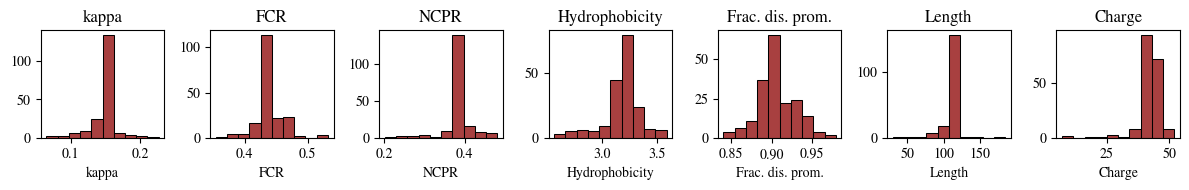

In [54]:
from residues import residues
residues.set_index('one', inplace=True)# Plotting CIDER parameters distribution
fig, axes = plt.subplots(ncols=len(cider.columns), figsize=(12,2))

# Looping over subplots and parameters
for ax, col in zip(axes, cider.columns):
    sns.histplot(data=cider, x=col, bins=10, ax=ax, color='darkred')
    ax.set_ylabel(None)
    ax.set_title(col)

plt.tight_layout()
plt.show()

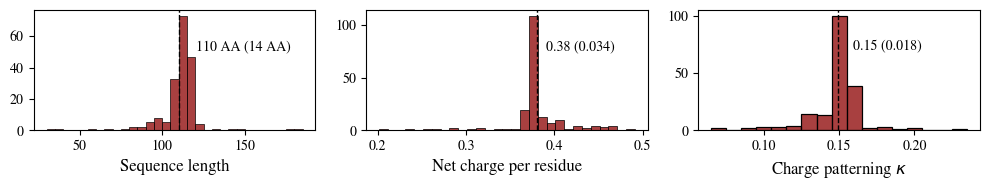

In [98]:
plt.figure(figsize=(10,2))

plt.subplot(131)
ax = sns.histplot(cider.Length, color='darkred', binwidth=5)
ax.set_ylabel(None)
ax.set_xlabel("Sequence length", fontsize=12)
ax.vlines(cider.Length.mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(cider.Length.mean()+10, ax.set_ylim()[1]*3/4, f"{cider.Length.mean():.0f} AA ({cider.Length.std():.0f} AA)", va='top')

plt.subplot(132)
ax = sns.histplot(cider.NCPR, color='darkred', binwidth=0.01)
ax.set_ylabel(None)
ax.set_xlabel("Net charge per residue", fontsize=12)
ax.vlines(cider.NCPR.mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(cider.NCPR.mean()+0.01, ax.set_ylim()[1]*3/4, f"{cider.NCPR.mean():.02f} ({cider.NCPR.std():.03f})", va='top')

plt.subplot(133)
ax = sns.histplot(cider.kappa, color='darkred', binwidth=0.01)
ax.set_ylabel(None)
ax.set_xlabel("Charge patterning $\kappa$", fontsize=12)
ax.vlines(cider.kappa.mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(cider.kappa.mean()+0.01, ax.set_ylim()[1]*3/4, f"{cider.kappa.mean():.02f} ({cider.kappa.std():.03f})", va='top')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Net charge per residue')

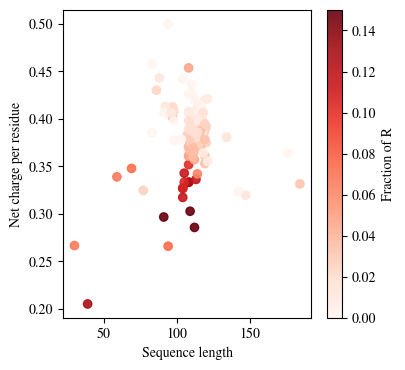

In [154]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(cider.Length, freqs.K, alpha=0.9, cmap='Reds', c=freqs.R, vmin=0, vmax=0.15)
plt.colorbar(label='Fraction of R')
ax.set_xlabel("Sequence length")
ax.set_ylabel("Net charge per residue")

##### Charge patterning

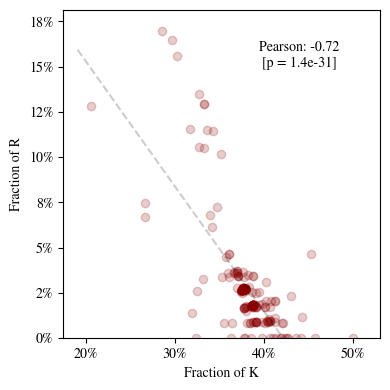

In [15]:
# Extracting charge related data
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(freqs.K*100, freqs.R*100, color='darkred', alpha=0.2)
ax.set_xlabel("Fraction of K")
ax.set_ylabel("Fraction of R")
xticks = mtick.FormatStrFormatter("%.0f%%")
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)
corr, corr_p = pearsonr(freqs.K, freqs.R)
slope, intercept = np.polyfit(freqs.K, freqs.R, 1)
ax.plot(ax.get_xlim(), [slope*x+intercept*100 for x in ax.get_xlim()], label=f"Pearson: {corr:.2f}\n  [p = {corr_p:.1e}]", color='k', linestyle='--', alpha=0.2)
ax.set_ylim(0)
ax.text(44, 15, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center')
#ax.legend()

plt.tight_layout()

#### Amino acid content

In [3]:
# Calculating frequencies
freqs = analyse_utils.amino_acid_content(metadata.sequence)

freqs

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0_AUSLI,0.247863,0.0,0.008547,0.017094,0.008547,0.025641,0.008547,0.008547,0.384615,0.008547,0.000000,0.000000,0.119658,0.000000,0.008547,0.051282,0.051282,0.051282,0.0,0.0
1_CYPVA,0.224138,0.0,0.008621,0.017241,0.008621,0.025862,0.008621,0.008621,0.387931,0.008621,0.000000,0.000000,0.137931,0.000000,0.017241,0.025862,0.068966,0.051724,0.0,0.0
2_FUNHE,0.232759,0.0,0.008621,0.017241,0.008621,0.025862,0.008621,0.008621,0.370690,0.008621,0.000000,0.000000,0.129310,0.000000,0.034483,0.034483,0.060345,0.051724,0.0,0.0
3_KRYMA,0.237288,0.0,0.008475,0.016949,0.008475,0.033898,0.008475,0.008475,0.381356,0.008475,0.008475,0.000000,0.127119,0.000000,0.008475,0.050847,0.050847,0.042373,0.0,0.0
4_NOTFU,0.243478,0.0,0.008696,0.017391,0.008696,0.026087,0.008696,0.008696,0.391304,0.008696,0.000000,0.000000,0.130435,0.000000,0.017391,0.052174,0.043478,0.034783,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190_NECAM,0.102564,0.0,0.000000,0.051282,0.000000,0.025641,0.000000,0.000000,0.205128,0.000000,0.000000,0.025641,0.025641,0.025641,0.128205,0.153846,0.128205,0.128205,0.0,0.0
191_STRRB,0.144578,0.0,0.048193,0.036145,0.000000,0.000000,0.000000,0.012048,0.385542,0.024096,0.000000,0.012048,0.036145,0.000000,0.000000,0.084337,0.120482,0.096386,0.0,0.0
192_CAPO3,0.394366,0.0,0.028169,0.042254,0.000000,0.000000,0.000000,0.007042,0.323944,0.007042,0.000000,0.000000,0.183099,0.000000,0.000000,0.000000,0.007042,0.007042,0.0,0.0
193_STRPU,0.239583,0.0,0.000000,0.010417,0.010417,0.052083,0.010417,0.000000,0.406250,0.020833,0.000000,0.000000,0.093750,0.000000,0.010417,0.031250,0.062500,0.052083,0.0,0.0


In [ ]:
# Calculating average number of AAs
pd.DataFrame(freqs.mean() * cider.Length.mean()).transpose()

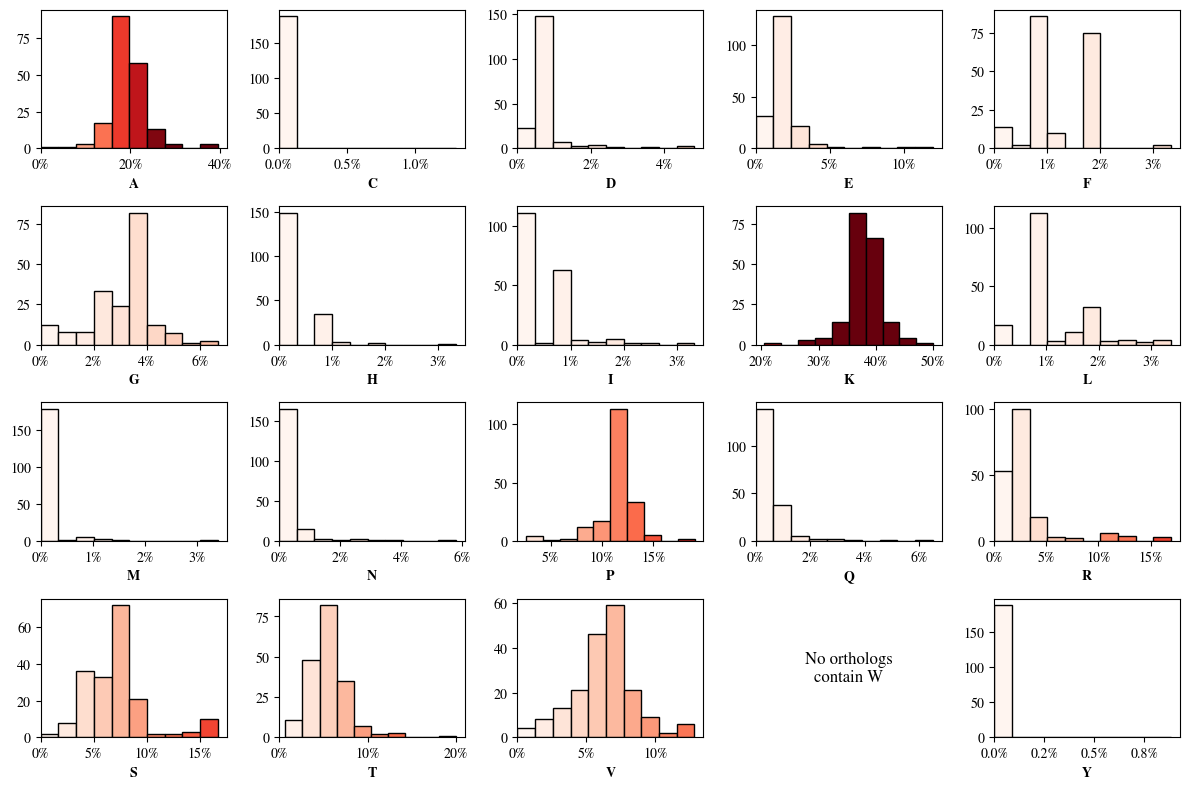

In [151]:
# Plotting distributions
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(12,8))
amino_acids = np.reshape(analyse_utils.amino_acids, dimensions)
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]
        aa = amino_acids[i,j]

        if freqs[aa].max() == 0:
            ax.axis('off')
            ax.text(0.5,0.5, f"No orthologs\ncontain {aa}", ha='center', va='center', fontsize=12)
            continue

        hist = sns.histplot(data=freqs*100, x=aa, bins=10, ax=ax)

        ax.set_ylabel(None)
        ax.set_xlabel(aa, fontweight="bold")
        if hist.get_xlim()[-1] < 2:
            xticks = mtick.FormatStrFormatter("%.1f%%")
        else:
            xticks = mtick.FormatStrFormatter("%.0f%%")
        ax.xaxis.set_major_formatter(xticks)
        if hist.get_xlim()[0] < 0:
            ax.set_xlim(left=0)

        for rectangle in hist.patches:
            x = rectangle.xy[0]
            color = plt.cm.Reds(x/25)
            rectangle.set_fc(color)
        
        

plt.tight_layout()
plt.show()

In [3]:
# Background noice from IDRome

# Loading data
dfs = []
for filename in os.listdir('../comp_cons_search/data'):
    dfs.append(pd.read_csv('../comp_cons_search/data/'+filename))
data = pd.concat(dfs).dropna()

# Calculating frequncies
#background_freqs = analyse_utils.amino_acid_content(data.fasta).groupby(data.HUMAN).mean()

In [6]:
d = data.groupby('HUMAN').nu.mean()

<Axes: >

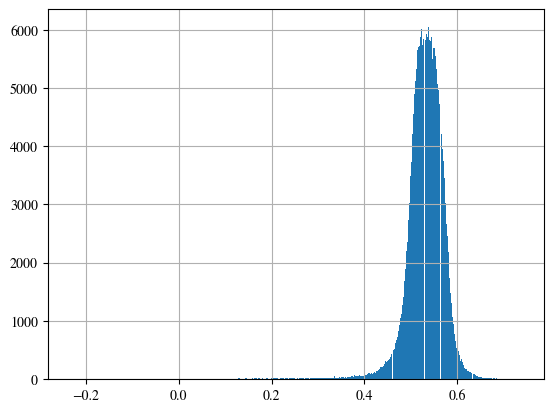

In [11]:
data.nu.hist(bins=1000)

In [8]:
(d < 0.67).sum() / len(d)

0.9999339498018494

In [30]:
# Background frequencies from IDRroam
content_background = background_freqs.mean().sort_values(ascending=False)
freqs = freqs[content_background.index]

(0.0, 52.5)

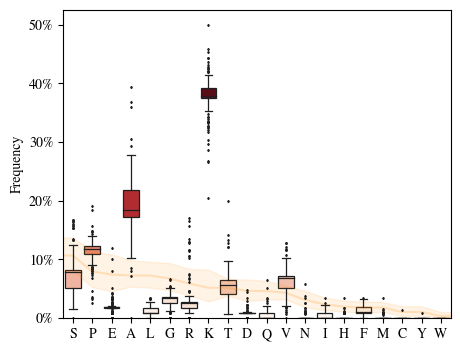

In [31]:
# Plotting amino acid distributions
fig, ax = plt.subplots(figsize=(5,4))
background_upper = (background_freqs.apply(lambda col: np.percentile(col, 25)))[[content_background.index[0], *content_background.index, content_background.index[-1]]]
background_lower = (background_freqs.apply(lambda col: np.percentile(col, 75)))[[content_background.index[0], *content_background.index, content_background.index[-1]]]
background_middle = (background_freqs.apply(np.median))[[content_background.index[0], *content_background.index, content_background.index[-1]]]
plt.fill_between(np.linspace(-1, 20, 22), background_lower*100, background_upper*100, alpha=0.1, color='darkorange')
plt.plot(np.linspace(-1, 20, 22), background_middle*100, alpha=0.2, color='darkorange')
boxplot = sns.boxplot(data=freqs*100, ax=ax, palette=sns.color_palette('Reds',as_cmap=True)(freqs.mean()/0.25), fliersize=1, linewidth=0.9, order=content_background.index.to_list())
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))
plt.ylabel("Frequency")
plt.ylim(0)

In [48]:
freqs_types

Polar          0.135432
Hydrophobic    0.283319
Special        0.144415
Negative       0.028210
Positive       0.408624
dtype: float64

(0.0, 52.5)

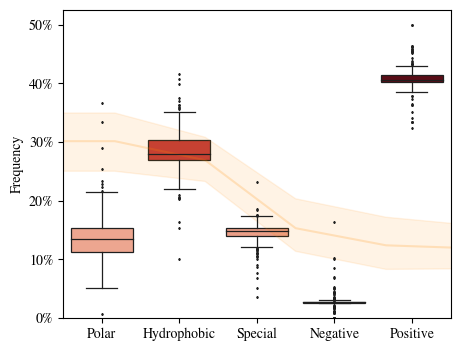

In [76]:
# Summing to types
freqs_types = freqs.groupby(analyse_utils.amino_acid_types, axis=1).sum()
background_types = background_freqs.groupby(analyse_utils.amino_acid_types, axis=1).sum()
type_background = background_types.mean().sort_values(ascending=False)
freqs_types = freqs_types[type_background.index]

# Plotting amino acid type distributions
fig, ax = plt.subplots(figsize=(5,4))
n = len(type_background)
background_upper = (background_types.apply(lambda col: np.percentile(col, 25)))[[type_background.index[0], *type_background.index, type_background.index[-1]]]
background_lower = (background_types.apply(lambda col: np.percentile(col, 75)))[[type_background.index[0], *type_background.index, type_background.index[-1]]]
background_middle = (background_types.apply(np.median))[[type_background.index[0], *type_background.index, type_background.index[-1]]]
plt.fill_between(np.linspace(-1, n+1, n+2), background_lower*100, background_upper*100, alpha=0.1, color='darkorange')
plt.plot(np.linspace(-1, n+1, n+2), background_middle*100, alpha=0.2, color='darkorange')
boxplot = sns.boxplot(data=freqs_types*100, ax=ax, palette=sns.color_palette('Reds',as_cmap=True)(freqs_types.mean()/0.4), fliersize=1, linewidth=0.9, order=type_background.index.to_list())
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))
plt.ylabel("Frequency")
plt.ylim(0)
#plt.xticks(range(5), labels=['Polar\nC H N\nQ S T Y', 'Hydrophobic\nA F I\nL M V W', 'Special\nG P', 'Positive\nK R', 'Negative\nD E'])

/tmp/ipykernel_44448/2652291291.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))


Text(0.34636180664694327, 0.9772393910636197, 'Other 12.3%')

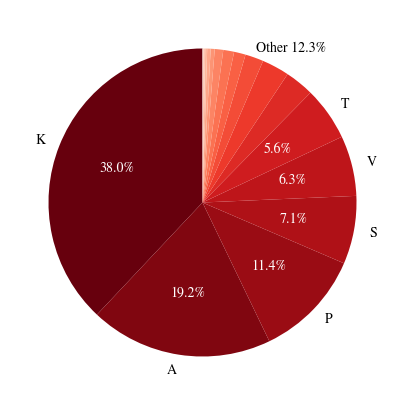

In [121]:
# Plotting distributions for H1.0
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(5, 5))
data = freqs.mean().sort_values(ascending=False)
patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))

other = []
for f, text, autotext in zip(data, texts, autotexts):
    autotext.set_color('white')
    if f < 0.05:
        text.set_visible(False)
        autotext.set_visible(False)
        other.append((f, text, autotext))

other_x = (other[0][1].get_position()[0] + other[-1][1].get_position()[0])/2
other_y = (other[0][1].get_position()[1] + other[-1][1].get_position()[1])/2
other_pct = sum([float(aa[2].get_text()[:-1])/100 for aa in other])
ax.text(other_x, other_y, f"Other {other_pct:.1%}")


In [ ]:
# Plotting distributions for H1.0
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(5, 5))
data = freqs.mean().sort_values(ascending=False)
patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))

other = []
for f, text, autotext in zip(data, texts, autotexts):
    autotext.set_color('white')
    if f < 0.05:
        text.set_visible(False)
        autotext.set_visible(False)
        other.append((f, text, autotext))

other_x = (other[0][1].get_position()[0] + other[-1][1].get_position()[0])/2
other_y = (other[0][1].get_position()[1] + other[-1][1].get_position()[1])/2
other_pct = sum([float(aa[2].get_text()[:-1])/100 for aa in other])
ax.text(other_x, other_y, f"Other {other_pct:.1%}")


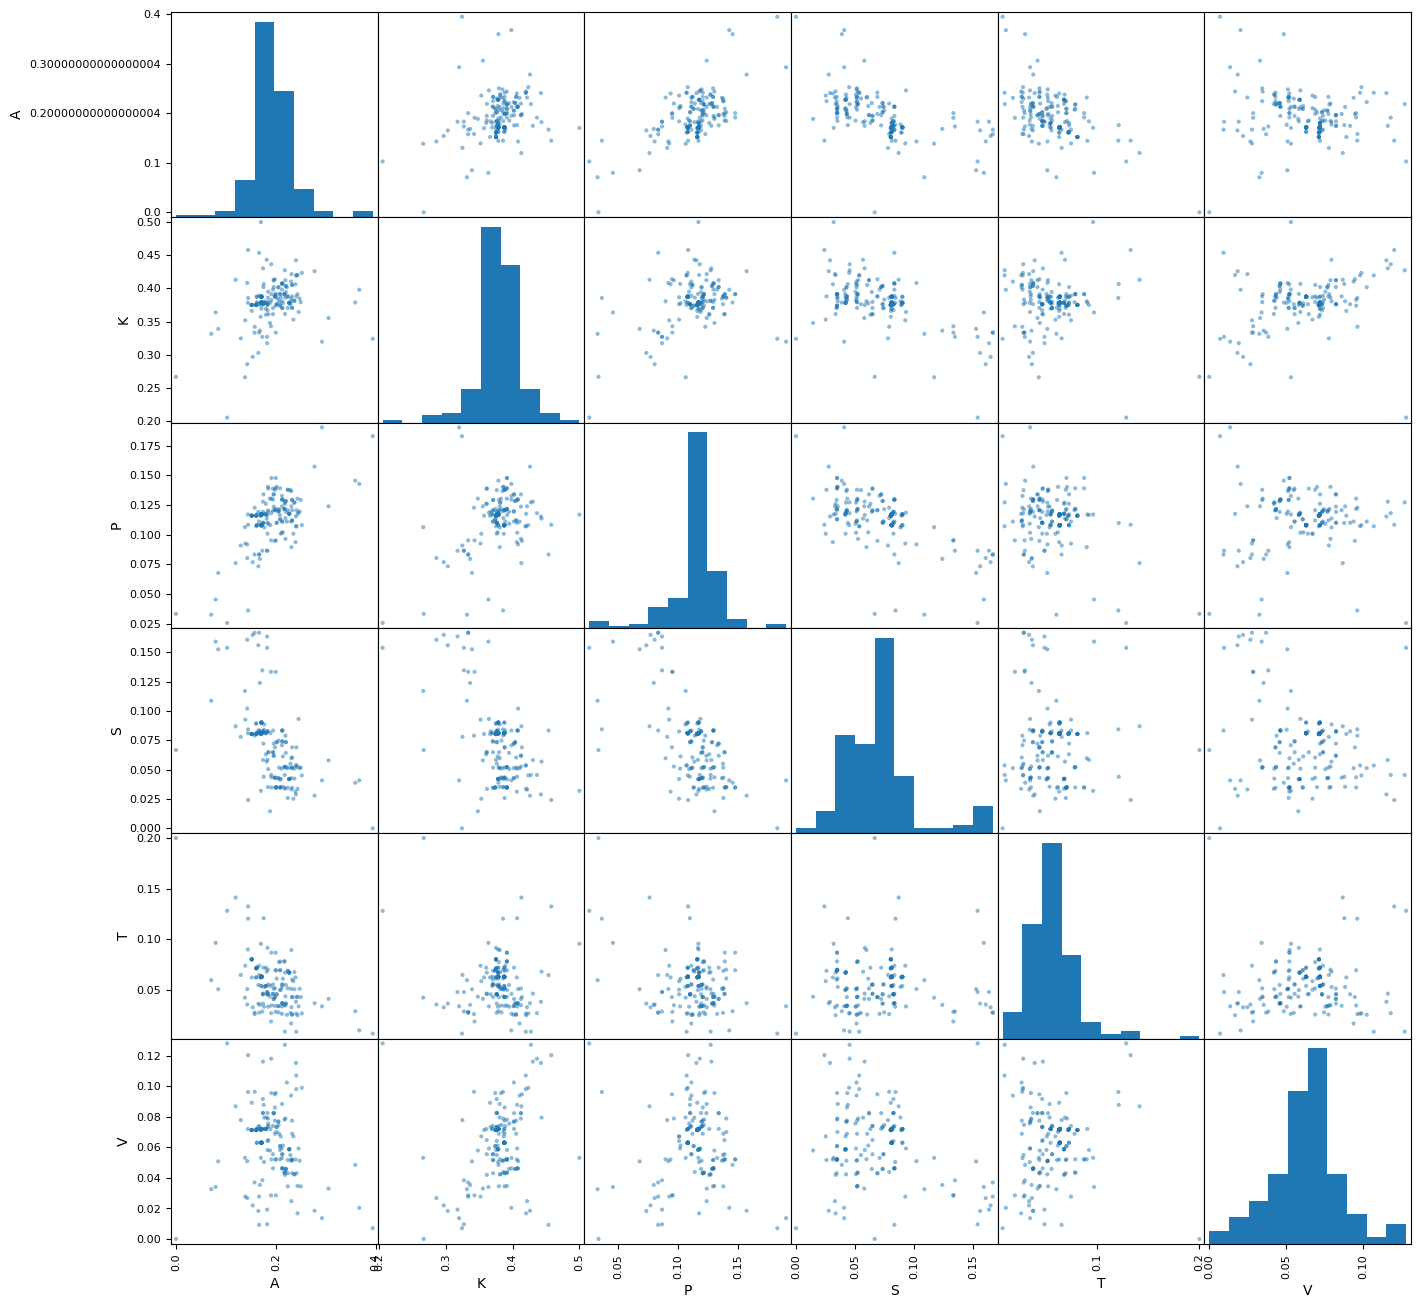

In [6]:
# Plotting a scatter matrix for most common residue types
_ = pd.plotting.scatter_matrix(freqs.loc[:, freqs.mean() > 1/20], figsize=(16, 16))

#### CALVADOS hydrophobicity

Text(0.5, 0, '')

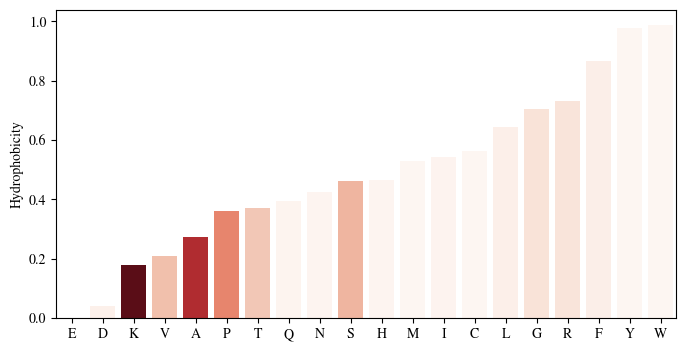

In [ ]:
plt.figure(figsize=(8,4))
aas = freqs.mean().transpose()[residues.index]
sns.barplot(x=residues.index, y=residues.AH_lambda, palette=plt.cm.Reds(aas/0.25))
plt.ylabel('Hydrophobicity')
plt.xlabel('')

(0.0006935460962935, 0.9893764740371644)

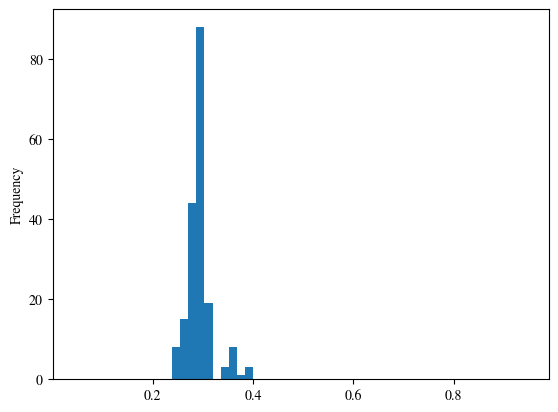

In [ ]:
metadata.sequence.apply(list).apply(lambda seq: residues.loc[seq].AH_lambda.mean()).plot.hist()
plt.xlim(residues.AH_lambda.min(), residues.AH_lambda.max())

#### Sequence identity

In [3]:
# Generating random sequences for alignment from each original sequence to check identity robustness
seqs = metadata.sequence
shuffled_seqs = seqs.apply(data_utils.shuffle_seq)

In [10]:
# Saving sequences for Jalview
with open("data/WT H1.0-CTD.fasta", 'w') as file:
    for i, seq in zip(seqs.index, seqs):
        file.write(f">{i}"+'\n')
        file.write(seq+'\n')
with open("data/Shuffled H1.0-CTD.fasta", 'w') as file:
    for i, seq in enumerate(shuffled_seqs):
        file.write(f">{i}"+'\n')
        file.write(seq+'\n')

In [211]:
# Loading alignment
from Bio import SeqIO
alignment = pd.DataFrame(columns=['aligned_seq'])
with open("results/alignments/WT H1.0-CTD (aligned).fasta", 'r') as file:
    for record in SeqIO.parse(file, format='fasta'):
        idx = record.id.split('/')[0]
        alignment.loc[idx] = str(record.seq)

#alignment = pd.DataFrame(alignment.aligned_seq.apply(list).to_list(), columns=range(len(alignment.iloc[0,0])), index=alignment.index)

alignment

,aligned_seq
0_AUSLI,-------HTKGIGASGSFRLT---KPED----------SSKKPA--...
100_LEPWE,--------TKGVGASGSFRLA---KSDE--------------PK--...
101_LYNCA,--------TKGVGASGSFRLA---KSDE--------------PK--...
102_MUSPF,-------QTKGVGASGSFRLA---KSDE--------------PK--...
103_MYODS,----------GVGASGSFRLA---KSDE--------------PK--...
...,...
96_CALUR,--------TKGVGASGSFRLA---KSDE--------------PK--...
97_CAPHI,--------TKGVGASGSFRLA---KSDE--------------PK--...
98_DESRO,--------TKGVGASGSFRLA---KSDE--------------PK--...
99_ENHLU,--------TKGVGASGSFRLA---KSDE--------------PK--...


In [247]:
# Calculating sequence identity as interpreted from Bellay 2011
aligned_seqs = np.array(alignment.aligned_seq.apply(list).to_list())
aas = np.array(analyse_utils.amino_acids)

# Calculating frequency of amino acids in each position, choosing maximum frequency at each position as identity at that position, calculating mean identity
identity = (aligned_seqs[:,:,np.newaxis] == aas).mean(axis=0).max(axis=1)
gaps = (aligned_seqs == '-').mean(axis=0) > identity

In [248]:
# Consensus sequence
consensus = ''.join(aas[(aligned_seqs[:,:,np.newaxis] == aas).mean(axis=0).argmax(axis=1)][~gaps])
consensus

'TKGVGASGSFRLAKSDEPKKSVAFKKTKKEVKKVATPKKAAKPKKAASKAPSKKPKATPVKKAKKKPAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKKAGKKK'

In [249]:
# Phosphorylation by CDK: S/T-P-X-K/R motif
CDK_motifs = []
for i in range(len(consensus)-3):
    m = consensus[i:i+3+1]
    
    if not m[0] in ['S', 'T']:
        continue

    if not m[1] == 'P':
        continue

    if not m[3] in ['K', 'R']:
        continue

    CDK_motifs.append((i, i+3))

print(CDK_motifs)

CDK_pos = []
for m in CDK_motifs:
    CDK_pos += [*range(m[0], m[1]+1)]

[(35, 38), (57, 60), (69, 72)]


In [250]:
# DNA-binding motif
DNA_motifs = []
for i in range(len(consensus)-3):
    if consensus[i:i+2+1] in ['KPK']:
        print(consensus[i:i+2+1])
        DNA_motifs.append((i, i+2))
    elif consensus[i:i+3+1] in ['SPRK', 'SPRR', 'SPKK', 'SPKR', 'TPRK', 'TPRR','TPKK','TPKR']:
        print(consensus[i:i+3+1])
        DNA_motifs.append((i, i+3))
    elif consensus[i:i+4+1] in ['PKAAK']:
        print(consensus[i:i+4+1])
        DNA_motifs.append((i, i+4))

print(DNA_motifs)

DNA_pos = []
for m in DNA_motifs:
    DNA_pos += [*range(m[0], m[1]+1)]
DNA_pos = sorted([*set(DNA_pos)])

TPKK
KPK
KPK
TPKK
KPK
KPK
KPK
[(35, 38), (41, 43), (53, 55), (69, 72), (75, 77), (88, 90), (96, 98)]


0.33497102544721596


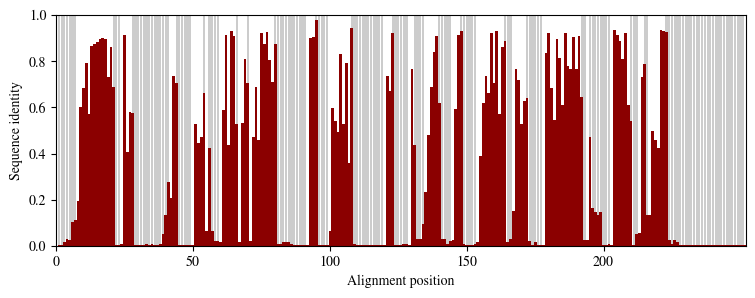

In [251]:
# Plotting full alignment
plt.figure(figsize=(8.9,3))
plt.bar(np.where(gaps)[0], 1, color='k', alpha=0.2, label='Gaps')
plt.bar([i+1 for i in range(len(identity))], identity, color="darkred", width=1)
plt.xlim(1, len(identity))
plt.ylim(0,1)
plt.xlabel("Alignment position")
plt.ylabel("Sequence identity")
plt.xticks([0,50,100,150,200])
print(identity.mean())

0.7252967252967252


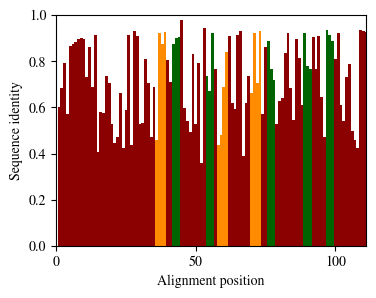

In [263]:
# Plotting gap-filtered alignment
plt.figure(figsize=(4,3))
plt.bar([i+1 for i in range(len(identity[~gaps]))], identity[~gaps], color="darkred", width=1)
plt.bar([i+1 for i in DNA_pos], identity[~gaps][DNA_pos], color="darkgreen", width=1)
plt.bar([i+1 for i in CDK_pos], identity[~gaps][CDK_pos], color="darkorange", width=1)
plt.xlim(1, len(identity[~gaps]))
plt.ylim(0,1)
plt.xlabel("Alignment position")
plt.ylabel("Sequence identity")
plt.xticks([0,50,100])
print(identity[~gaps].mean())

In [257]:
# Subsampling all alignment and calculating sequence identity
from tqdm import tqdm
from random import random
bootstrap = pd.DataFrame(columns=['p_wt', 'identity', 'identity_nogaps'])
for i in tqdm(range(1000)):

    n = len(alignment)//2
    n_wt = 0
    while n_wt == 0:
        n_wt = round(random()*n)
    wt_sample = metadata.sample(n_wt).index
    rand_sample = [str(metadata.index.get_loc(idx)) for idx in metadata[~metadata.index.isin(wt_sample)].index]
    subsample = alignment.loc[[*wt_sample,*rand_sample]]

    # Calculating sequence identity as interpreted from Bellay 2011
    aligned_seqs = np.array(subsample.aligned_seq.apply(list).to_list())
    aas = np.array(analyse_utils.amino_acids)

    # Calculating frequency of amino acids in each position, choosing maximum frequency at each position as identity at that position, calculating mean identity
    identity = (aligned_seqs[:,:,np.newaxis] == aas).mean(axis=0).max(axis=1)
    gaps = (aligned_seqs == '-').mean(axis=0) > identity

    # Calculating fraction of WT sequences in sample
    p_wt = n_wt/len(subsample)

    bootstrap.loc[i] = (p_wt, identity.mean(), identity[~gaps].mean())

100%|██████████| 1000/1000 [00:46<00:00, 21.53it/s]


/tmp/ipykernel_44448/3058019636.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])


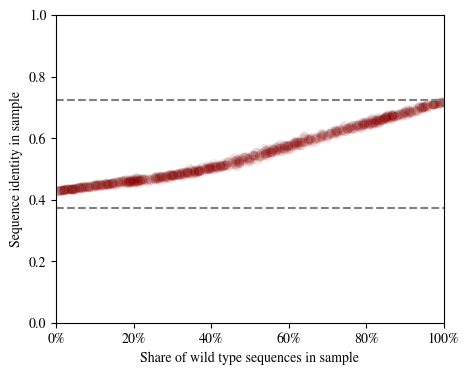

In [369]:
plt.figure(figsize=(5,4))
plt.scatter(bootstrap.p_wt, bootstrap.identity_nogaps, color='darkred', alpha=0.05, label='Sample alignment')
#plt.title("Sequency identity in polluted alignment\n(Alignment of 50% WT + 50% Shuffled)")
plt.xlabel("Share of wild type sequences in sample")
plt.ylabel("Sequence identity in sample")
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_xticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.hlines([0.373, 0.725], 0, 1, linestyles='--', color='grey', label='Identity in 100% WT / 100% Shuffled')
#plt.legend(loc='lower right')

##### Benchmarking against folded domains

In [36]:
# Looping over orthologs
from tqdm import tqdm
domains = []
for uid in tqdm(metadata.uniprot_id):

    # Fetching UniProt XML record
    record = data_utils.get_protein_txt_record(uid)

    # Finding folded domains
    for feature in record.features:
        if 'H15' in feature.qualifiers.values():
            start = int(feature.location.start)
            end = int(feature.location.end)
            domains.append(record.sequence[start:end])

100%|██████████| 189/189 [00:51<00:00,  3.70it/s]


In [232]:
# Saving sequences for Jalview
with open("data/WT H1.0-H15.fasta", 'w') as file:
    for i, seq in zip(metadata.index, domains):
        file.write(f">{i}"+'\n')
        file.write(seq+'\n')

(0.0, 1.0)

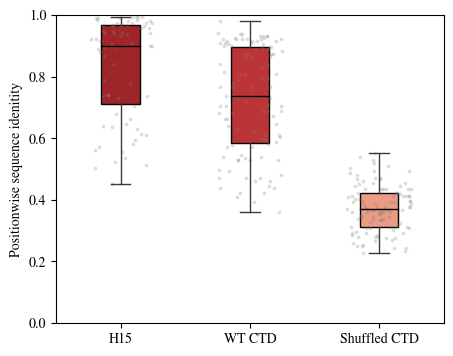

In [210]:
# Identities
benchmark = pd.Series({
    'H15': wt_h15,
    'WT CTD': wt_ctd,
    'Shuffled CTD': shuffled_ctd
}).explode()

plt.figure(figsize=(5,4))
sns.boxplot(x=benchmark.index, y=benchmark, fliersize=1, linewidth=1, width=0.3, palette=plt.cm.Reds(benchmark.groupby(benchmark.index).mean())[[0,2,1]], boxprops=dict(edgecolor='k'), flierprops=dict(color='k'), medianprops=dict(color='k'))
for i, idx in enumerate(np.unique(benchmark.index)[[0,2,1]]):
    b = benchmark[benchmark.index == idx]
    plt.scatter(np.random.rand(len(b))/2+i-0.25, b, s=3, alpha=0.2, color='grey')
plt.ylabel("Positionwise sequence idenitity")
plt.ylim(0,1)

In [108]:
pd.Series({
    'H15': wt_h15,
    'CTD': wt_ctd,
    'Shuffled CTD': shuffled_ctd
}).explode()

H15             0.513228
H15             0.962963
H15             0.968254
H15             0.867725
H15             0.973545
                  ...   
Shuffled CTD    0.010582
Shuffled CTD    0.005291
Shuffled CTD    0.015873
Shuffled CTD    0.005291
Shuffled CTD    0.010582
Length: 539, dtype: object

#### Principal component analysis

In [8]:
# Performing PCA
# Standardising data
features = freqs
features = (features - features.mean()) / features.std()
features.fillna(0, inplace=True)

# Perform PCA
pca = PCA()

# Calculate principal components
pca_pcs = pd.DataFrame(pca.fit_transform(features), columns=[f'PC{i+1}' for i in range(len(features.columns))], index=features.index)

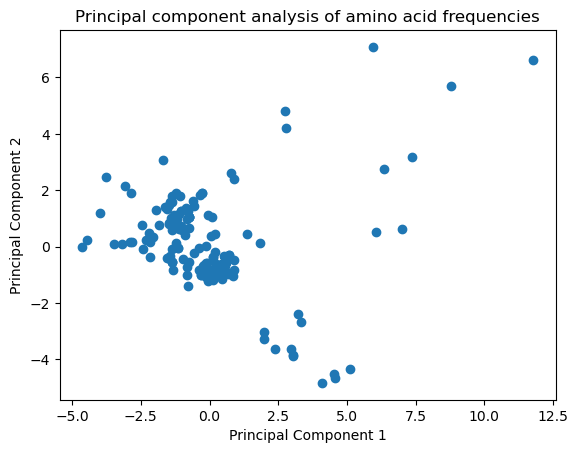

In [30]:
# Plot the first two principal components
plt.scatter(pca_pcs.PC1, pca_pcs.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Principal component analysis of amino acid frequencies")
plt.show()

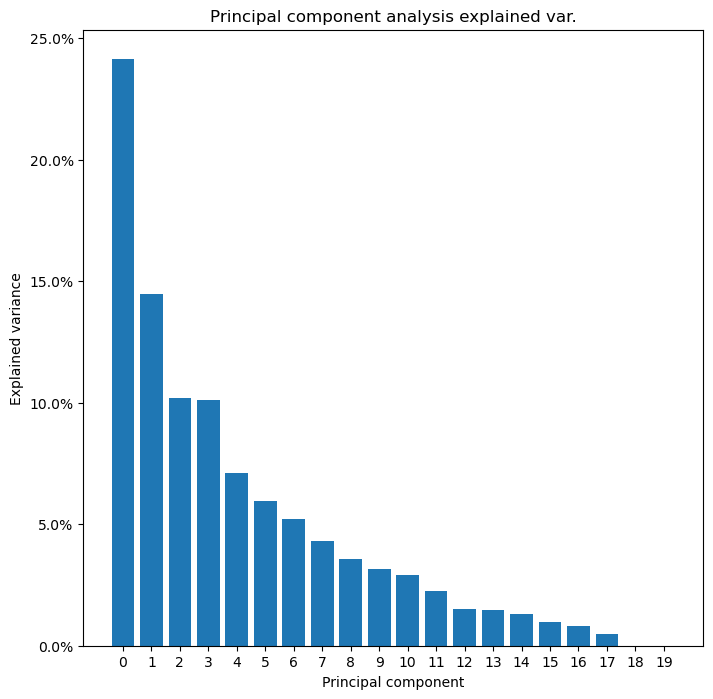

In [ ]:
# Plot the explained variance
plt.bar(range(len(features.columns)), pca.explained_variance_ratio_)
plt.xticks(range(len(features.columns)))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.title('Principal component analysis explained var.')
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

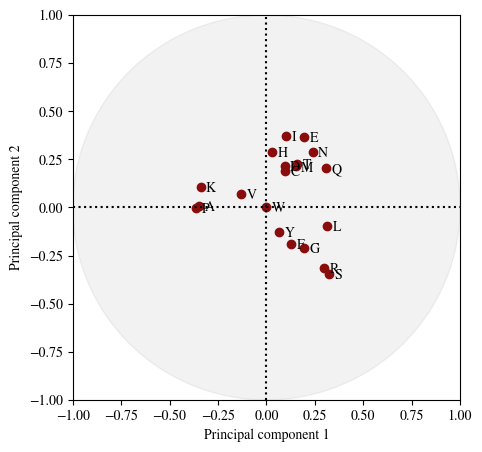

In [31]:
# Plotting rotational matrix for first two PCs
rotation_matrix = pca.components_.T
pc_x = 0
pc_y = 1
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(rotation_matrix[:,pc_x], rotation_matrix[:,pc_y], color='darkred')
for i, feature_name in enumerate(features.columns):
    ax.annotate(feature_name, (rotation_matrix[i,pc_x]+0.028, rotation_matrix[i,pc_y]-0.025))
ax.set_xlabel(f'Principal component {pc_x+1}')
ax.set_ylabel(f'Principal component {pc_y+1}')
ax.hlines(0,-1, 1, 'k', 'dotted')
ax.vlines(0,-1, 1, 'k', 'dotted')
ax.add_patch(plt.Circle((0,0), 1, color='grey', alpha=0.1))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

(-1.0, 1.0)

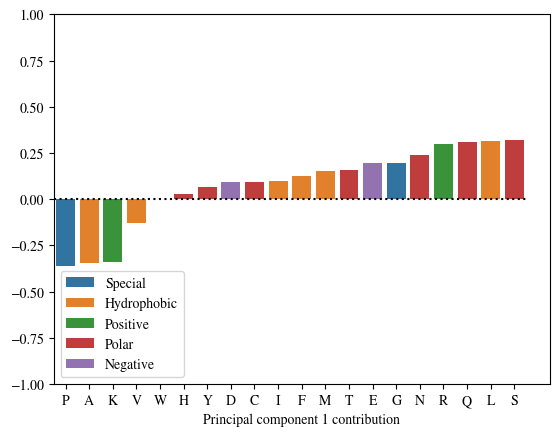

In [171]:
# Plotting feature contribution to component
pc_x = 0
order = rotation_matrix[:,pc_x].argsort()
sns.barplot(x=features.columns[order], y=rotation_matrix[:,pc_x][order], hue=np.array([*analyse_utils.amino_acid_types.values()])[order], dodge=False)
plt.xlabel(f'Principal component {pc_x+1} contribution')
plt.hlines(0, -0.5, 19.5, 'k', 'dotted')
plt.xlim(-0.5,20.5)
plt.ylim(-1,1)

#### Clustering

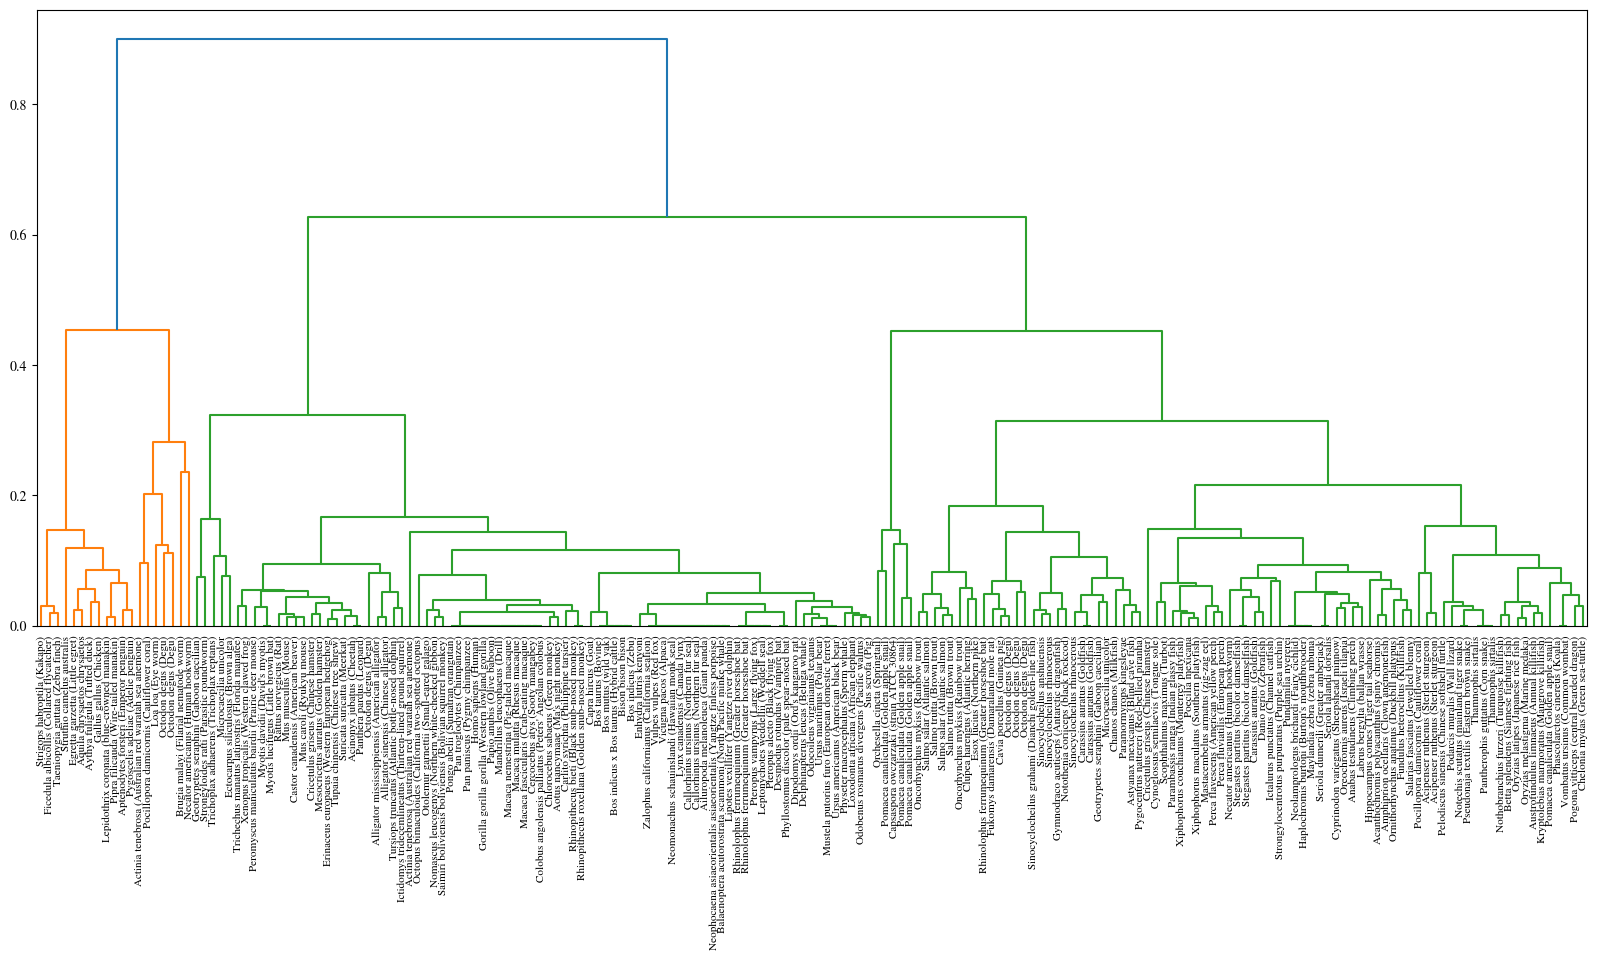

In [171]:
# Hierarchical clustering
linkage_data = linkage(freqs, method='ward', metric='euclidean')
plt.figure(figsize=(20,8))
dendrogram(linkage_data, leaf_font_size=8, labels=metadata.species)
plt.show()

In [21]:
# Assigning labels
n_clusters = 2
clusters = pd.Series(AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(freqs), index=freqs.index)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Structural descriptors

In [7]:
struc = pd.DataFrame()

In [8]:
# Computing radius of gyration
struc['Rg'] = metadata.apply(lambda row: analyse_utils.compute_rg(row.traj), axis=1)
struc['<Rg>'] = struc.apply(lambda row: row.Rg.mean(), axis=1)

In [10]:
# Computing end-to-end distance
struc['Re'] = metadata.apply(lambda row: analyse_utils.compute_end_to_end(row.traj), axis=1)
struc['<Re>'] = struc.apply(lambda row: row.Re.mean(), axis=1)

In [9]:
# Computing asphericity
struc['Delta'] = metadata.apply(lambda row: analyse_utils.compute_asphericity(row.traj), axis=1)

In [10]:
# Computing prolateness
struc['S'] = metadata.apply(lambda row: analyse_utils.compute_prolateness(row.traj), axis=1)

In [11]:
# Computing scaling exponent
struc['nu'] = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=0.518, ij_cutoff=10)[0], axis=1)

In [25]:
# Displaying descriptors
struc

,Rg,$\Delta$,S,$\nu$,<R_g>
0_AUSLI,"[5.339063047761628, 5.274882060805913, 4.97212...",0.270023,1.422065,0.667791,4.381407
1_CYPVA,"[3.6350766680547686, 3.781398727213607, 3.4927...",0.268131,1.417615,0.669772,4.393022
2_FUNHE,"[5.346823559166943, 5.006208357159023, 4.72734...",0.263601,1.409343,0.668862,4.369886
3_KRYMA,"[4.350247334604474, 4.31563248842799, 4.389371...",0.268578,1.420866,0.666119,4.356704
4_NOTFU,"[4.489363428806459, 3.634504861905979, 3.23643...",0.263502,1.406296,0.669369,4.358040
...,...,...,...,...,...
190_NECAM,"[2.039577492308271, 2.0292645118518937, 1.9009...",0.265204,1.393662,0.630547,1.912896
191_STRRB,"[3.592746072534665, 4.160118103787323, 3.66844...",0.267684,1.419162,0.656172,3.350389
192_CAPO3,"[4.527172690792832, 4.314376590712447, 3.62197...",0.268813,1.367527,0.645315,4.497810
193_STRPU,"[4.3452603808920784, 4.6299968206583095, 4.640...",0.269512,1.413519,0.672527,3.917294


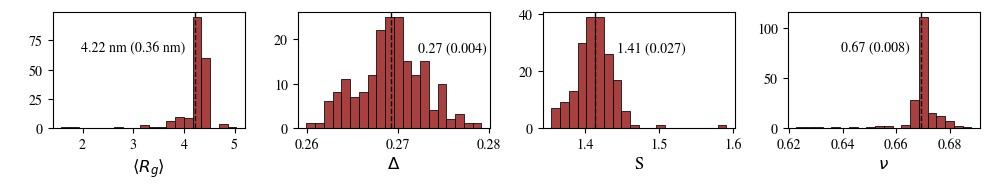

In [53]:
plt.figure(figsize=(10,2))

plt.subplot(141)
ax = sns.histplot(struc['<R_g>'], color='darkred', bins=20)
ax.set_xlabel("$\left\langle R_g \\right\\rangle$", fontsize=12)
ax.set_ylabel(' ')
ax.vlines(struc['<R_g>'].mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(struc['<R_g>'].mean()-0.2, ax.set_ylim()[1]*3/4, f"{struc['<R_g>'].mean():.2f} nm ({struc['<R_g>'].std():.2f} nm)", va='top', ha='right')

plt.subplot(142)
ax = sns.histplot(struc['Delta'], color='darkred', bins=20)
ax.set_xlabel("$\Delta$", fontsize=12)
ax.set_ylabel(None)
ax.vlines(struc['Delta'].mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(struc['Delta'].mean()+0.003, ax.set_ylim()[1]*3/4, f"{struc['Delta'].mean():.2f} ({struc['Delta'].std():.3f})", va='top')

plt.subplot(143)
ax = sns.histplot(struc.S_, color='darkred', bins=20)
ax.set_xlabel("S", fontsize=12)
ax.set_ylabel(None)
ax.vlines(struc.S_.mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(struc.S_.mean()+0.03, ax.set_ylim()[1]*3/4, f"{struc.S_.mean():.2f} ({struc.S_.std():.3f})", va='top', ha='left')

plt.subplot(144)
ax = sns.histplot(struc['nu'], color='darkred', bins=20)
ax.set_xlabel("$\\nu$", fontsize=12)
ax.set_ylabel(None)
ax.vlines(struc['nu'].mean(), 0, ax.set_ylim()[1], linestyles='--', color='black', linewidth=1)
ax.text(struc['nu'].mean()-0.004, ax.set_ylim()[1]*3/4, f"{struc['nu'].mean():.2f} ({struc['nu'].std():.3f})", va='top', ha='right')

plt.tight_layout()
plt.show()

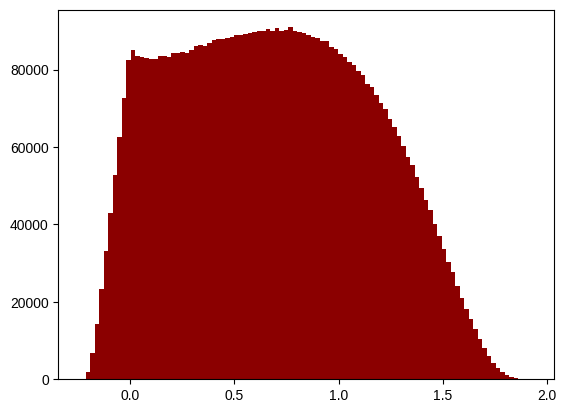

In [167]:
_ = plt.hist(struc.S.explode(), bins=100, color='darkred')

In [125]:
cider.select_dtypes(include=[np.number]).corrwith(struc.nu)

kappa              -0.182858
FCR                 0.267530
NCPR                0.929970
Hydrophobicity      0.066172
Frac. dis. prom.    0.212768
Length             -0.018679
Charge              0.657033
dtype: float64

In [132]:
cider.select_dtypes(include=[np.number]).corrwith(struc['<R_g>'])

kappa               0.079287
FCR                 0.041555
NCPR                0.204530
Hydrophobicity      0.227757
Frac. dis. prom.    0.332680
Length              0.911713
Charge              0.909281
dtype: float64

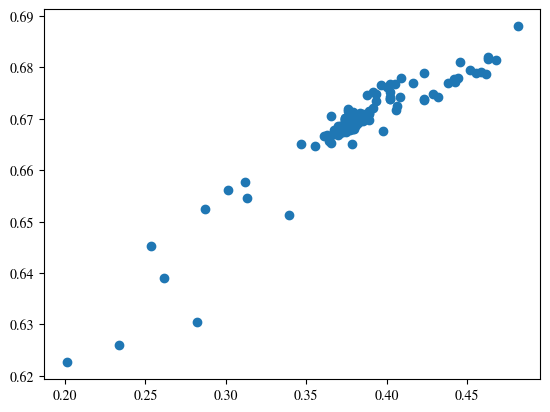

In [118]:
plt.scatter(cider.NCPR, struc.nu)

#### Outlier filtering

In [11]:
# Setting outliers by sequence length (75<=L<=125) and scaling exponent (0.65<v)
struc['outlier'] = ~((abs(cider.Length-100)<=25) & (struc.nu>0.65))
struc['outlier'].sum()

/tmp/ipykernel_19533/1513490438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  struc['outlier'] = ~((abs(cider.Length-100)<=25) & (struc.nu>0.65))


9

In [48]:
# Mean values amongst filtered
pd.concat([struc[~struc['outlier']][['<Rg>', '<Re>', '<Delta>', '<S>', 'v']].mean(), cider[~struc['outlier']][['Length']].mean()])

<Rg>         4.257806
<Re>        10.592716
<Delta>      0.201365
<S>          0.683427
v            0.661649
Length     110.728814
dtype: float64

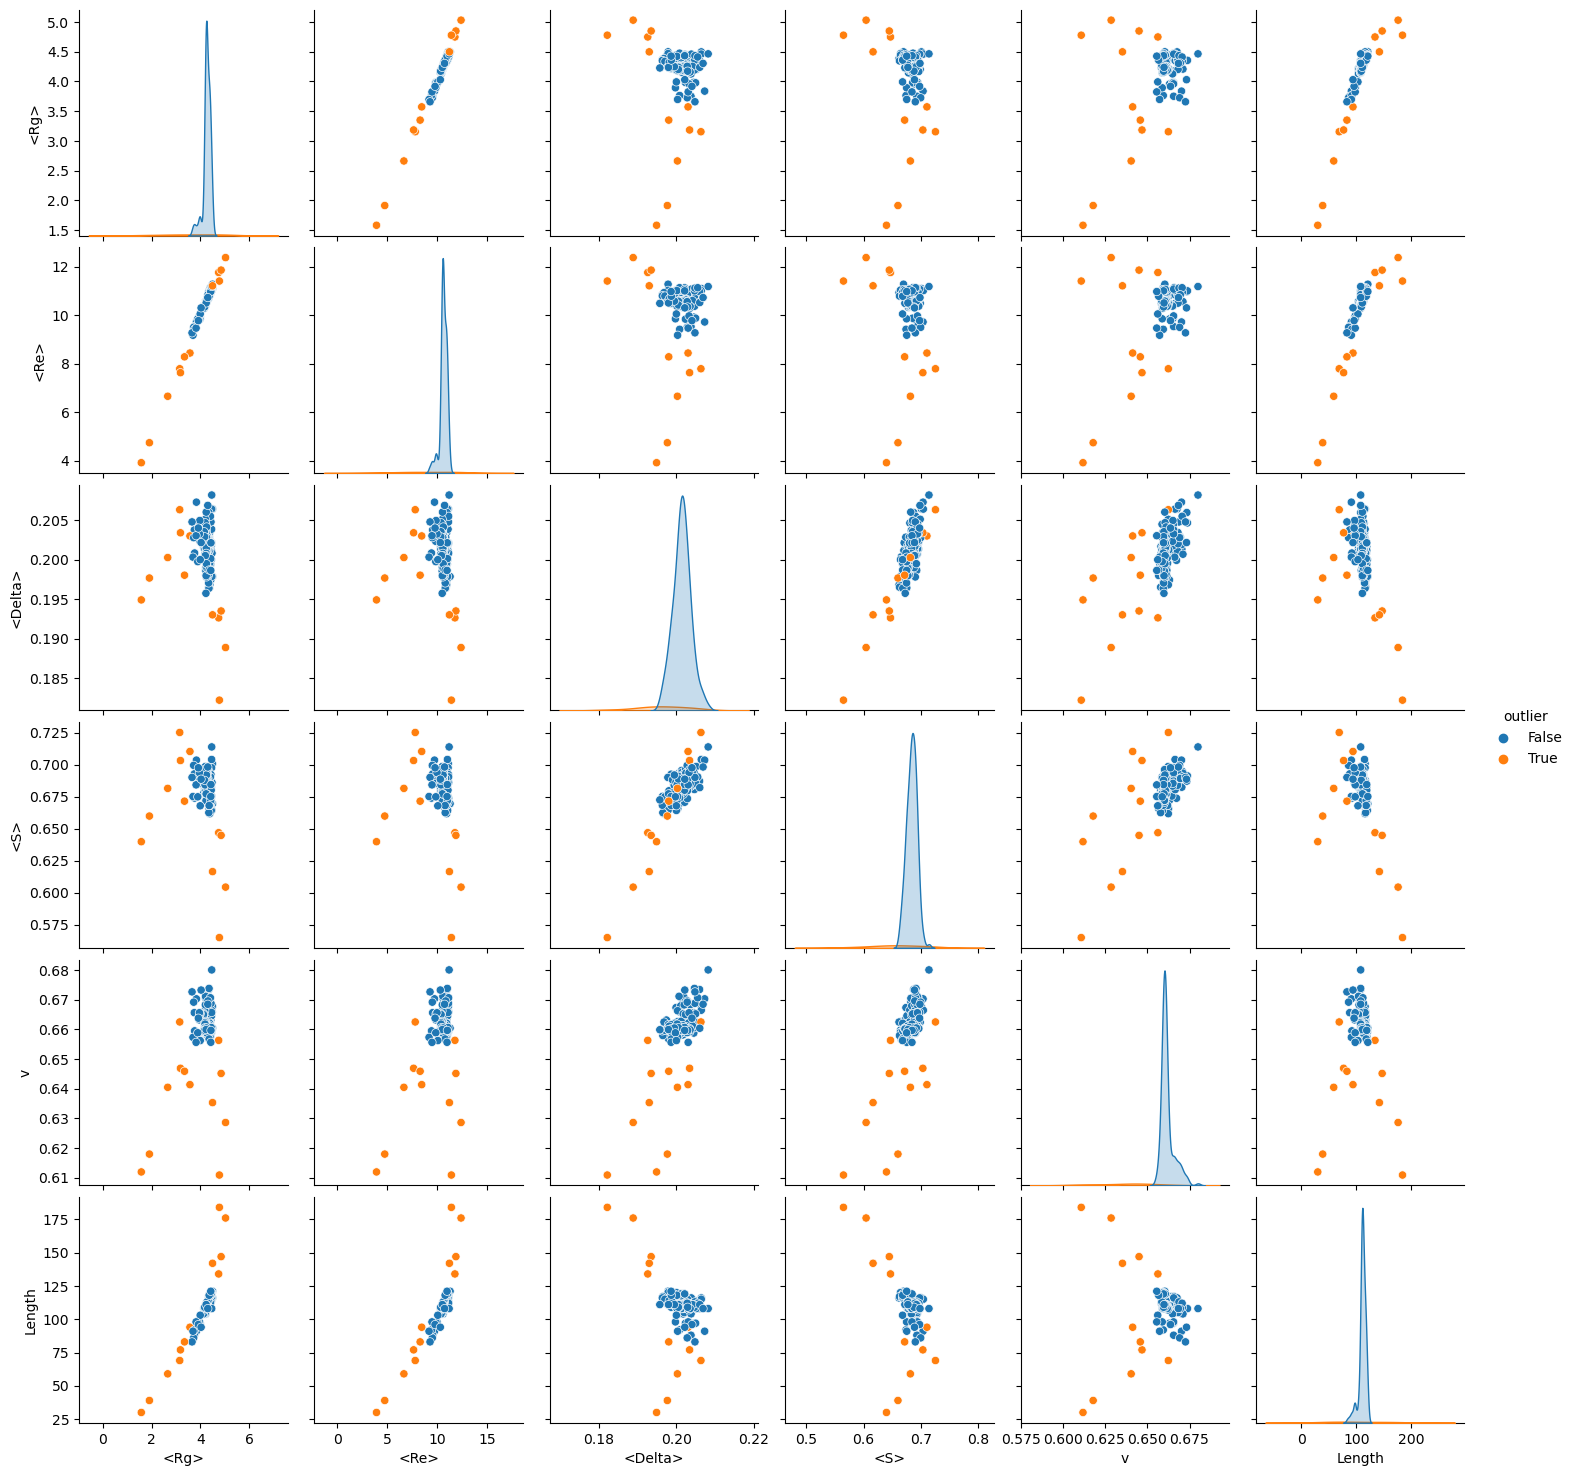

In [51]:
# Plotting distributions
sns.pairplot(pd.concat([struc[['<Rg>', '<Re>', '<Delta>', '<S>', 'v', 'outlier']], cider[['Length']]], axis=1), hue='outlier')

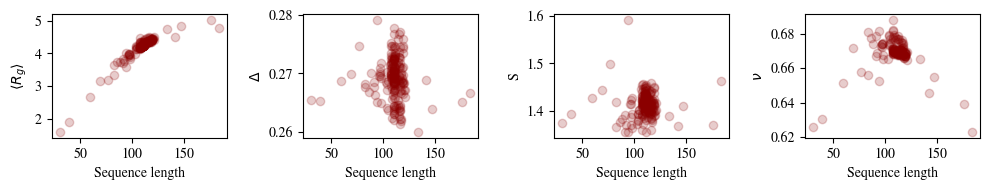

In [65]:
fig, axes = plt.subplots(1,4, figsize=(10,2))

ax = axes[0]
ax.scatter(cider.Length, struc['<R_g>'], color='darkred', alpha=0.2)
ax.set_xlabel("Sequence length")
ax.set_ylabel("$\left\langle R_g \\right\\rangle$")

ax = axes[1]
ax.scatter(cider.Length, struc.Delta, color='darkred', alpha=0.2)
ax.set_xlabel("Sequence length")
ax.set_ylabel('$\Delta$')

ax = axes[2]
ax.scatter(cider.Length, struc.S_, color='darkred', alpha=0.2)
ax.set_xlabel("Sequence length")
ax.set_ylabel('S')

ax = axes[3]
ax.scatter(cider.Length, struc.nu, color='darkred', alpha=0.2)
ax.set_xlabel("Sequence length")
ax.set_ylabel('$\\nu$')

plt.tight_layout()
plt.show()

#### Scan of $R_0$ for scaling exponent

The scan is performed using SBATCH

<Axes: >

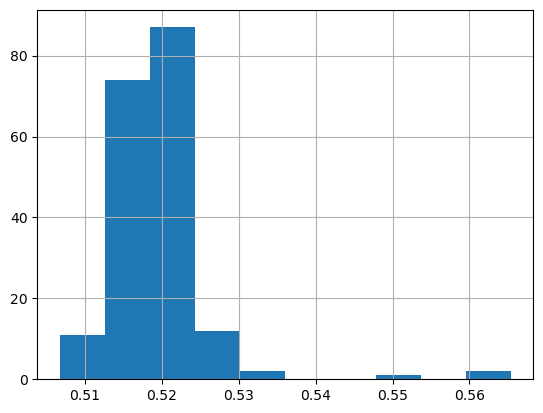

In [51]:
# Determining scan range
fits = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None, ij_cutoff=10), axis=1)
fits = pd.concat([fits.explode()[0::4], fits.explode()[2::4]], axis=1)
fits.columns = ['v', 'r0']
fits.r0.hist()

In [81]:
# Loading scan
scan = pd.read_csv("results/r0_scan.csv", index_col=0)
scan.columns = scan.columns.astype(float)
scan

,0.500,0.501,0.502,0.503,0.504,0.505,0.506,0.507,0.508,0.509,...,0.591,0.592,0.593,0.594,0.595,0.596,0.597,0.598,0.599,0.600
id,,,,,,,,,,,,,,,,,,,,,
185_BRUMA,0.116352,0.115513,0.114689,0.113881,0.113088,0.112310,0.111547,0.110799,0.110066,0.109348,...,0.093995,0.094265,0.094544,0.094833,0.095131,0.095438,0.095755,0.096081,0.096416,0.096760
190_NECAM,0.170532,0.169539,0.168589,0.167683,0.166820,0.166001,0.165225,0.164491,0.163800,0.163150,...,0.233635,0.235791,0.237975,0.240185,0.242422,0.244685,0.246974,0.249290,0.251631,0.253998
187_LOALO,0.832709,0.829086,0.825649,0.822397,0.819331,0.816448,0.813748,0.811230,0.808893,0.806735,...,1.159532,1.169419,1.179422,1.189541,1.199774,1.210122,1.220584,1.231159,1.241847,1.252647
126_CRIGR,2.941360,2.936098,2.931149,2.926510,2.922179,2.918155,2.914437,2.911022,2.907909,2.905096,...,3.561093,3.578458,3.596018,3.613772,3.631720,3.649860,3.668191,3.686712,3.705423,3.724323
138_OCTDE,13.183748,13.173716,13.164113,13.154938,13.146188,13.137861,13.129954,13.122466,13.115394,13.108736,...,13.787765,13.809018,13.830543,13.852337,13.874400,13.896730,13.919326,13.942186,13.965310,13.988695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98_DESRO,15.721159,15.700611,15.681211,15.662954,15.645834,15.629844,15.614980,15.601235,15.588604,15.577080,...,17.926215,17.989922,18.054366,18.119542,18.185449,18.252081,18.319436,18.387511,18.456302,18.525805
97_CAPHI,15.635126,15.611013,15.588052,15.566236,15.545562,15.526021,15.507609,15.490320,15.474148,15.459088,...,17.529862,17.590313,17.651504,17.713431,17.776090,17.839480,17.903595,17.968433,18.033990,18.100263
99_ENHLU,16.092618,16.075736,16.059993,16.045385,16.031904,16.019547,16.008306,15.998175,15.989151,15.981226,...,18.599711,18.666417,18.733852,18.802015,18.870901,18.940507,19.010829,19.081864,19.153610,19.226062


Text(0.518, 2475.6180885350486, 'Best $R_0$: 0.518')

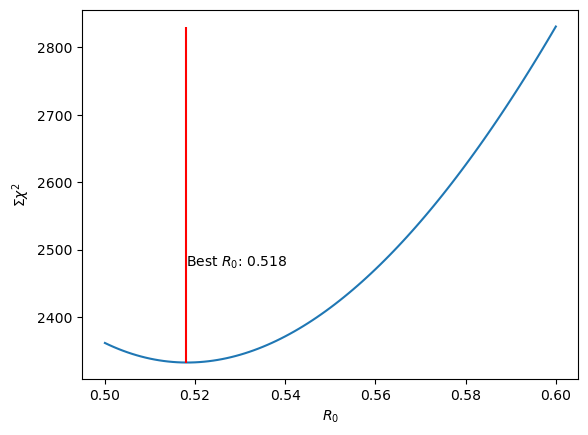

In [90]:
# Finding best R0 value
scan.sum().plot()
best_r0 = float(scan.transpose().loc[scan.sum() == scan.sum().min()].index[0])
plt.vlines(best_r0, scan.sum().min(), scan.sum().max(), color="r")
plt.xlabel("$R_{0}$")
plt.ylabel("$\Sigma\chi^{2}$")
plt.text(best_r0, scan.sum().mean(), f"Best $R_{0}$: {best_r0}")